In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import datetime
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-05-17 00:21:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  91.7MB/s    in 1.8s    

2022-05-17 00:21:10 (91.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wing

In [4]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(1/255.)
test_datagen = ImageDataGenerator(1/255.)

print("Training images: ")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Test images: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images: 
Found 750 images belonging to 10 classes.
Test images: 
Found 2500 images belonging to 10 classes.


In [5]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard file to: {log_dir}")
  return tensorboard_callback

In [6]:
def create_model(model_url, num_classes=10):
  feature_extraction_layer = hub.KerasLayer(model_url,
                                            trainable=False,
                                            name="feature_extraction_layer",
                                            input_shape=IMAGE_SHAPE+(3,))
  
  model = tf.keras.Sequential([
                               feature_extraction_layer,
                               tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [7]:
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

# 1
mobilenet_model = create_model(mobilenet_url,
                               num_classes=train_data.num_classes)

# 2
mobilenet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

# 3
mobilenet_history = mobilenet_model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.5 * len(test_data)),
                    callbacks=[create_tensorboard_callback(dir_name="tensorboard_hub",
                                                           experiment_name="mobilenetv2")])

Saving TensorBoard file to: tensorboard_hub/mobilenetv2/20220517-002118


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/5
24/24 [==============================] - 28s 621ms/step - loss: 2.4270 - accuracy: 0.1360 - val_loss: 2.2407 - val_accuracy: 0.1851
Epoch 2/5
24/24 [==============================] - 14s 589ms/step - loss: 2.0920 - accuracy: 0.2427 - val_loss: 2.1165 - val_accuracy: 0.2484
Epoch 3/5
24/24 [==============================] - 14s 588ms/step - loss: 1.9554 - accuracy: 0.3053 - val_loss: 2.0859 - val_accuracy: 0.2500
Epoch 4/5
24/24 [==============================] - 9s 392ms/step - loss: 1.8572 - accuracy: 0.3347 - val_loss: 2.0733 - val_accuracy: 0.2644
Epoch 5/5
24/24 [==============================] - 14s 590ms/step - loss: 1.7656 - accuracy: 0.4093 - val_loss: 2.0272 - val_accuracy: 0.2620


In [8]:
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"] 

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy") 
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


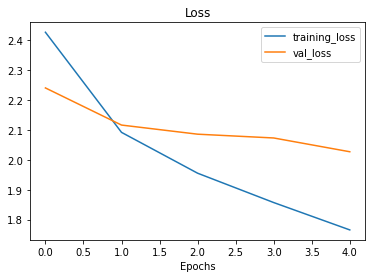

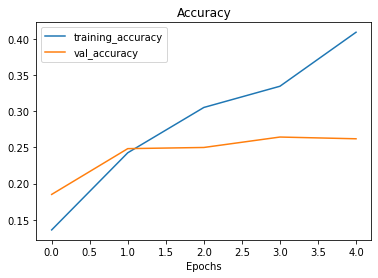

In [9]:
plot_loss_curves(mobilenet_history)

In [10]:
# 4
mobilenet_model.evaluate(test_data)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


79/79 [==============================] - 12s 150ms/step - loss: 1.9998 - accuracy: 0.2884


[1.999781608581543, 0.28839999437332153]

In [11]:
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


Import dependencies and TensorBoard notebook extension

In [12]:
import time
import PIL.Image as Image
%load_ext tensorboard 

Import pre-trained models, MobileNet and Inception

In [15]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

Define image shape and batch size. 

Add output layer

In [16]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

classifier = tf.keras.Sequential([
                                  hub.KerasLayer(classifier_model,
                                                 input_shape=IMAGE_SHAPE+(3,))
])

Import image for prediction and resize it

73728/61306 [====================================] - 0s 0us/step


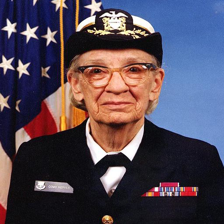

In [17]:
grace_hopper = tf.keras.utils.get_file("image.jpeg", "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg")
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

Normalize the image by dividing it by 255.0

In [18]:
grace_hopper = np.array(grace_hopper)/255.
grace_hopper.shape

(224, 224, 3)

Add batch dimension with np.newaxis and pass the  image to the model

In [20]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The top class ID can be found using argmax function from the last axis (axis=-1)

In [22]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

Take the predicted class and fetch the ImageNet dataset to decode the predictions

In [23]:
labels_path = tf.keras.utils.get_file("ImageNetLabels.txt", "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt")
imagenet_labels = np.array(open(labels_path).read().splitlines())

24576/10484 [======================================================================] - 0s 0us/step


Visualize the prediction

Text(0.5, 1.0, 'Prediction: Military Uniform')

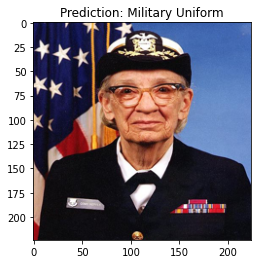

In [25]:
plt.imshow(grace_hopper)
plt.axis=False
predicted_class_name = imagenet_labels[predicted_class]
plt.title("Prediction: " + predicted_class_name.title())